In [1]:
!pip install torch torchvision

**Allowing Access to Google Drive**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q "drive/My Drive/ZIP_FILES/archive.zip" -d "Dataset" | head -n 5


# **Importing libraries**

In [ ]:
import torch
import datetime
from matplotlib.pyplot import imshow, imsave
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from PIL import Image

# **Importing the python function files**

In [ ]:
from modelDCGAN import Discriminator, Generator
from dataloader import CARS

# Model configuration

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (32, 32, 3)
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result


# Initialize models
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)#Load discriminator
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)# Load generator

# Other code snippets for training
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0], IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [ ]:
dataset = CARS(data_path='Dataset/archive/cars_train/cars_train', transform=transform)#Load images

batch_size = 64


data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)


criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))


max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

# **Training the model**

In [ ]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            # create folder by right clicking in the file window and name the folder 'samples'
            imsave('content/samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.4001, G Loss: 0.8396, Time:07:49:37
Epoch: 3/100, Step: 500, D Loss: 0.6704, G Loss: 1.4225, Time:07:54:49
Epoch: 7/100, Step: 1000, D Loss: 0.5354, G Loss: 2.5682, Time:08:00:02
Epoch: 11/100, Step: 1500, D Loss: 0.6198, G Loss: 2.6072, Time:08:05:12
Epoch: 15/100, Step: 2000, D Loss: 0.5475, G Loss: 2.9984, Time:08:10:21
Epoch: 19/100, Step: 2500, D Loss: 0.5733, G Loss: 2.5246, Time:08:15:31
Epoch: 23/100, Step: 3000, D Loss: 1.1062, G Loss: 3.1924, Time:08:20:46
Epoch: 27/100, Step: 3500, D Loss: 0.8687, G Loss: 3.1570, Time:08:25:52
Epoch: 31/100, Step: 4000, D Loss: 0.9602, G Loss: 2.0037, Time:08:31:01
Epoch: 35/100, Step: 4500, D Loss: 1.0253, G Loss: 3.2012, Time:08:36:14
Epoch: 39/100, Step: 5000, D Loss: 1.7009, G Loss: 5.2752, Time:08:41:23
Epoch: 43/100, Step: 5500, D Loss: 0.6786, G Loss: 1.6774, Time:08:46:32
Epoch: 47/100, Step: 6000, D Loss: 0.5115, G Loss: 2.5447, Time:08:51:42
Epoch: 51/100, Step: 6500, D Loss: 0.4908, G Loss: 5.1582,

# **Evaluating results**

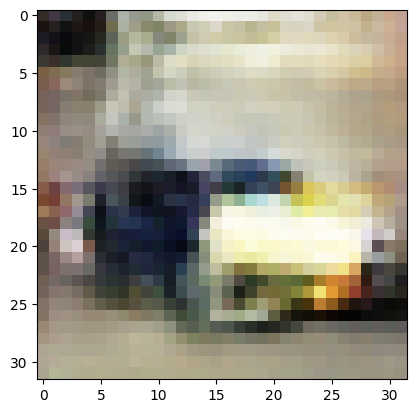

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise)[3]) #Generator image

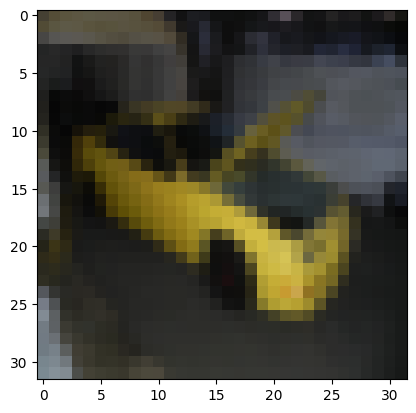

In [ ]:
t = Image.open(dataset.fpaths[876])#random sample image from dataset
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)
